# Exploring and Cleaning the Data

This notebook goes through the steps used to begin exploring clean the raw data obtained. Before we can clean the data, it is important to understand the overall properties of the data. This can help identify data that is important to our goals and data that is unnecessary for training our desired model. Cleaning makes sure the tweets are in the best format for analysis and training a model for sentiment analysis.

__Columns__
- `target` sentiment of tweet (0=negative, 4=positive)
- `id` unique identifier of tweet
- `date` date and time of tweet
- `flag` the query if one exists
- `user` user that authored the tweet
- `text` text content of the tweet, emoticons are removed

This data is publicly available on [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It is also avaliable for download from my Google Drive [here](https://drive.google.com/drive/folders/1A4SUadIiXHKV87THvu2qZl-1xGaO54B8?usp=sharing). 


It was created by the Bhayani and Huang for:

    Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

---

_Note:_ 
_This notebook expects the zipped dataset to be in your Google Drive in a `twitter_sentiment` sub-directory with the name `raw_twitter_data.zip`
(e.g., `./MyDrive/twitter_sentiment/raw_twitter_data.zip`). If this dataset is in another location set `RESOURCES_PATH` accordingly._

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q wordcloud
!pip install -q contractions
!pip install -q seaborn
!pip install -q sklearn

In [ ]:
import string
import re

from urllib.request import urlopen, Request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions

from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read File
Read the file into memory to determine its overall shape. If the file does not exist locally it is downloaded into the `./resources` directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
RESOURCES_PATH = './drive/MyDrive/twitter_sentiment/{}' #@param {type:"string"}
file_name = 'raw_twitter_data.zip'
file_path = RESOURCES_PATH.format(file_name)

In [ ]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv(file_path, encoding = 'ISO-8859-1', names=col_names, compression='zip')

In [ ]:
def df_summary(data_frame):
    BYTES_IN_MB = 1024**2
    print('Columns: {}'.format(data_frame.columns))
    print('Shape: {}'.format(data_frame.shape))
    print('Memory Usage:{:.4f} Mb'.format(data_frame.memory_usage().sum() / BYTES_IN_MB))

In [ ]:
df_summary(df)
df.head()

Columns: Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')
Shape: (1600000, 6)
Memory Usage:73.2423 Mb


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Remove Extra Columns
The only columns of real interest to train a model for tweet sentiment classification is the `target` and `text` columns. The `target` column indicates the sentiment of the tweet and `text` contains the text of the tweet.

In [ ]:
df.drop(['id', 'date', 'flag', 'user'], axis='columns', inplace=True)
df_summary(df)

Columns: Index(['target', 'text'], dtype='object')
Shape: (1600000, 2)
Memory Usage:24.4142 Mb


## Set Column Data Types

In [ ]:
df['text'] = df['text'].astype('str')
df['target'] = df['target'].astype('int64')

## Exploratory Analysis
Examining the data for differences in data points associated with different sentiments can help us understand if our data is balanced across our target categories. Additionally, it can helps use understand if we should direct the focus of our training on to or away from any data characteristics to get the best possible sentiment classification model.

### Meta Features
Examining meta features can help determine the best way to clean the data and help narrow down what types of models will be most successful for predicting the target of a tweet based on its text.

In [ ]:
df['num_words'] = df['text'].apply(lambda s: len(s.split(' ')))
df['num_unique_words'] = df['text'].apply(lambda s: len(set(s.split(' '))))
df['num_stop_words'] = df['text'].apply(lambda s: len([w for w in s.lower().split(' ') if w in STOPWORDS]))
df['avg_word_length'] = df['text'].apply(lambda s: np.mean([len(w) for w in s.split(' ')]))
df['num_chars'] = df['text'].apply(lambda s: len(s))
df['num_punctuation'] = df['text'].apply(lambda s: len([c for c in s if c in string.punctuation]))
df['num_urls'] = df['text'].apply(lambda s: len([w for w in s.lower().split() if 'http' in w or 'https' in w]))
df['num_hashtags'] = df['text'].apply(lambda s: len([c for c in s if c == '#']))
df['num_mentions'] = df['text'].apply(lambda s: len([c for c in s if c == '@']))

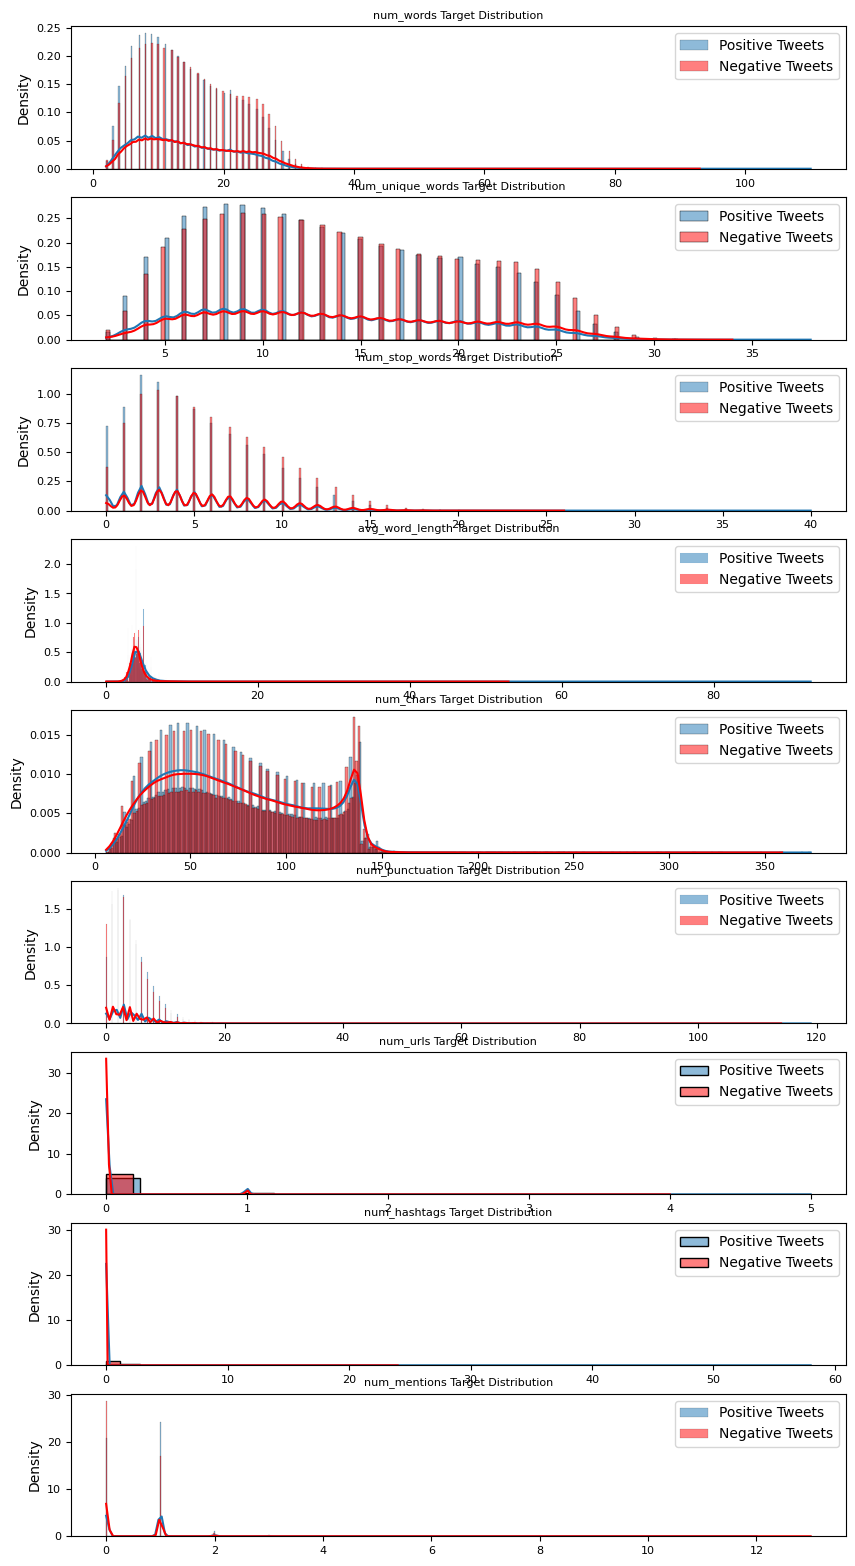

In [ ]:
meta_feature_cols = ['num_words', 'num_unique_words', 'num_stop_words', 'avg_word_length', 
                     'num_chars', 'num_punctuation', 'num_urls', 'num_hashtags', 'num_mentions']
positive_tweets = df['target'] == 4

figure, axes = plt.subplots(ncols=1, nrows=len(meta_feature_cols), figsize=(10,20), dpi=100)

for i, meta_feature in enumerate(meta_feature_cols):
    sns.histplot(df.loc[positive_tweets][meta_feature], kde=True, stat='density', label='Positive Tweets', ax=axes[i])
    sns.histplot(df.loc[~positive_tweets][meta_feature], kde=True, stat='density', label='Negative Tweets', ax=axes[i], color="red")
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].legend()
    
    axes[i].set_title('{} Target Distribution'.format(meta_feature), fontsize=8)
    
plt.show()

The analysis of meta features shows diversity among the targets in several features. Features such as `num_words`, `num_unique_words`, `num_punctuation`, `avg_word_length`, and `num_chars` have different distributions for positive and negative tweets. These features may be useful in our model. Features such as `num_stop_words` may also include valuable differences when it comes to predicting our target. Usually, this type of context data would be cleaned from tweets before training a standard model. [[1]](https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7) As a result, some of these features will be left in and model selection will have to take the existence of the features in the data into account. Generally, NLP includes preprocessing to remove all stop words and stem remaining verbs. However, for this data set that information scrubbing could result in loss of data important for our model. To determine which stop words add no value to our target predictions we can analyze the n-grams for the data set. Starting with a pre-trained BERT model and fine tuning it to handle target prediction should be used. A BERT model is designed to be used with NLP data that includes more grammatical context as it has been pre-trained by Google on a large corpus that includes documents and books. [[2]](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html?m=1)

## Cleaning

### Labels
To simply our target representation we will convert it to a boolean label: `0=Positive Tweet; 1=Negative Tweet`

In [ ]:
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

### Tweets
To increase the models ability to predicte the targets the tweets are cleaned. This process involves taking a tweet through several steps of processing: `to_lowercase`, `expand_contractions`, `entity_to_char`, `remove_links`, `remove_mentions`, `replace_slang`, `remove_special_chars`, `remove_puncuation`, and `trim_spaces`.

In [ ]:
def to_lowercase(s):
    return s.lower()

def remove_links(s):
    return re.sub(r'https?://[A-Za-z0-9./]+', '', s)

def expand_contractions(s):
    expanded = []
    for word in s.split():
        expanded.append(contractions.fix(word))
    return ' '.join(expanded)

def remove_mentions(s):
    return re.sub(r'(@[A-Za-z0-9_]+)', '', s)

def remove_puncuation(s):
    result = s.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    result = re.sub('[0-9]+', '', result)
    return result

def trim_spaces(s):
    result = re.sub('\t', ' ',  s)
    result = re.sub(' +', ' ', result)
    return result.strip()

def clean(s):
    result = remove_links(s)
    result = remove_mentions(result)
    result = expand_contractions(result)
    result = remove_puncuation(result)
    result = to_lowercase(result)
    result = trim_spaces(result)
    return result

In [ ]:
df['text'] = df['text'].apply(lambda s: clean(s))
df['text'].head(25)

0     awww that is a bummer you shoulda got david ca...
1     is upset that he can not update his facebook b...
2     i dived many times for the ball managed to sav...
3        my whole body feels itchy and like its on fire
4     no it is not behaving at all i am mad why am i...
5                                    not the whole crew
6                                            need a hug
7     hey long time no see yes rains a bit only a bi...
8                             nope they did not have it
9                                          que me muera
10             spring break in plain city it is snowing
11                             i just repierced my ears
12    i could not bear to watch it and i thought the...
13    it it counts idk why i did either you never ta...
14    i would have been the first but i did not have...
15    i wish i got to watch it with you i miss you a...
16    hollis death scene will hurt me severely to wa...
17                                  about to fil

### Clean Up Feature Analysis Columns

In [ ]:
training_columns = ['text', 'target']
df = df[training_columns]

### Missing Values
To determine how to clean the data we need to understand the extent of missing values.

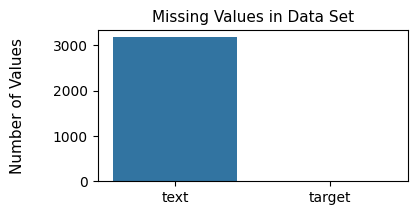

In [ ]:
df['text'].replace('', np.nan, inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(4, 2), dpi=100)

sns.barplot(x=df[training_columns].isnull().sum().index, y=df[training_columns].isnull().sum().values, ax=axes)

axes.set_ylabel('Number of Values', size=11, labelpad=20)
axes.tick_params(axis='x', labelsize=10)
axes.tick_params(axis='y', labelsize=10)

axes.set_title('Missing Values in Data Set', fontsize=11)

plt.show()

In [ ]:
df.dropna(inplace=True)

### Duplicates

In [ ]:
df.drop_duplicates(subset=training_columns, keep="first", inplace=True)

In [ ]:
df.drop_duplicates(subset=['text'], keep="first", inplace=True)

## Extract Sample
Due to the size of the dataset and the resources needed to train a model with 1.6 million tweets only a sample of 50,000 tweets will be used for analysis and training for the tweet sentiment classifier MVP.

In [ ]:
SAMPLE_PER_TARGET=25000
df = df.groupby('target').apply(lambda d: d.sample(n=SAMPLE_PER_TARGET)).reset_index(drop = True)

### Target
The target distributions in the data set are perfectly balanced. This means we don't need to account for any imbalances in target distributions when training or validating our model.

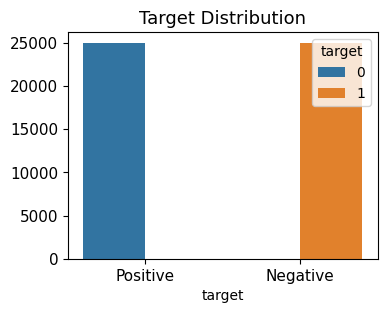

In [ ]:
target_balance = df.groupby('target')['target'].agg('count').values

fig, axes = plt.subplots(ncols=1, figsize=(4, 3), dpi=100)
sns.countplot(x=df['target'], hue=df['target'], ax=axes)

axes.set_ylabel('')
axes.set_xticklabels(['Positive', 'Negative'])
axes.tick_params(axis='x', labelsize=11)
axes.tick_params(axis='y', labelsize=11)

axes.set_title('Target Distribution', fontsize=13)

plt.show()

## Split Data Set: Training, Testing, Validation
The data is now ready for pre-processing and model training. It will be exported to a zip archive namee `clean_twitter_data.zip` contianing the comma-separated file `clean_twitter_data.csv`.

In [ ]:
DELIMITER = '=' * 5
print(DELIMITER + 'CLEAN' + DELIMITER)
df_summary(df)

=====CLEAN=====
Columns: Index(['text', 'target'], dtype='object')
Shape: (50000, 2)
Memory Usage:0.7631 Mb


In [ ]:
df.to_csv(RESOURCES_PATH.format('clean_twitter_data.zip'), compression=dict(method='zip', archive_name='clean_twitter_data.csv'), index=False, header=False)